# Policy analysis (with income loss)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator, MultipleLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from src.data.analyse import *
import ptitprince as pt
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [3]:
# Load results
income_loss = True
results = load_results(f'../results/scenarios=1000, policies=20, income_loss={income_loss}.tar.gz')

# Prepare outcomes data frame
outcomes = prepare_outcomes(results, add_policies=True)

# This outcome should be studied separately
outcomes.drop('years_in_poverty', axis=1, inplace=True)

# Split my policy into two columns
outcomes[['target_group', 'top_up']] = outcomes['my_policy'].str.split('+', expand=True)

# Make top_up a categorical variable to ensure it is ordered correctly
outcomes['top_up'] = pd.Categorical(outcomes['top_up'], categories=['0', 
                                                                    '10', 
                                                                    '30', 
                                                                    '50', 
                                                                    '100'])

## What is the impact of top-ups across target groups and districts?

In [21]:
df = outcomes.copy()
columns_of_interest = [
       'district',
       'target_group',
       'top_up', 
       'n_new_poor',
       'annual_average_consumption_loss_pct']
tab = df[columns_of_interest].round(2).groupby([
    'district',
    'target_group', 
    'top_up']).mean(numeric_only=True).round(2)

In [22]:
top_up_mapper = {'0' : 'None', '10' : '10%', '30': '30%', '50': '50%', '100': '100%'}
target_group_mapper = {'all' : 'All', 'poor' : 'Poor', 'poor_near_poor1.25' : 'Poor and Near Poor (1.25)', 'poor_near_poor2.0' : 'Poor and Near Poor (2.0)'}
outcome_name_mapper = {'annual_average_consumption_loss_pct' : 'Annual average consumption loss (%)', 'n_new_poor' : 'Number of new poor'}

tab.rename(index = top_up_mapper, inplace = True)
tab.rename(index = target_group_mapper, inplace = True)
tab.rename(columns = outcome_name_mapper, inplace = True)
tab.index.names = [
    'District',
    'Target group', 
    'Top-up (%)']

tab['Number of new poor'] = tab['Number of new poor'].astype(int)

In [25]:
outcomes['district'].unique()

array(['Anse-La-Raye & Canaries', 'Castries', 'Choiseul', 'Dennery',
       'Gros Islet', 'Laborie', 'Micoud', 'Soufriere', 'Vieuxfort'],
      dtype=object)

In [26]:
tab.loc['Micoud', :]

Number of new poor  \
Target group              Top-up (%)                       
All                       None                        71   
                          10%                         70   
                          30%                         64   
                          50%                         56   
                          100%                        37   
Poor                      None                        71   
                          10%                         71   
                          30%                         71   
                          50%                         71   
                          100%                        71   
Poor and Near Poor (1.25) None                        71   
                          10%                         71   
                          30%                         69   
                          50%                         66   
                          100%                        57   
Poor and Near Poor (2.0)  None                        71   
                          10%                         70   
                          30%                         64   
                          50%                         57   
                          100%                        38   

                                      Annual average consumption loss (%)  
Target group              Top-up (%)                                       
All                       None                                      15.96  
                          10%                                       15.33  
                          30%                                       14.04  
                          50%                                       12.72  
                          100%                                       9.28  
Poor                      None                                      15.96  
                          10%                                       15.88  
                          30%                                       15.72  
                          50%                                       15.55  
                          100%                                      15.12  
Poor and Near Poor (1.25) None                                      15.96  
                          10%                                       15.85  
                          30%                                       15.61  
                          50%                                       15.37  
                          100%                                      14.74  
Poor and Near Poor (2.0)  None                                      15.96  
                          10%                                       15.71  
                          30%                                       15.20  
                          50%                                       14.66  
                          100%                                      13.24

In [6]:
n_target_groups = 4
# n_target_groups = 1
k = 0
m_top_ups = 4
# m_top_ups = 2
for i in range(n_target_groups):
    x = tab.iloc[k, 0]
    y = tab.iloc[k, 1]
    tab.iloc[k, 0] = 0
    tab.iloc[k, 1] = 0
    for j in range(k + 1, k + m_top_ups + 1):
        tab.iloc[j, 0] = x - tab.iloc[j, 0]
        tab.iloc[j, 1] = y - tab.iloc[j, 1]
    k += m_top_ups + 1

tab.columns = ['Average number of people preventing from falling into poverty',
               'Average reduction in consumption loss (%)']
tab = tab + 0

In [7]:
tab

Average number of people preventing from falling into poverty  \
Target group              Top-up percentage                                                                  
All                       None                                                               0               
                          10%                                                                5               
                          30%                                                               17               
                          50%                                                               28               
                          100%                                                              60               
Poor                      None                                                               0               
                          10%                                                                0               
                          30%                                                                0               
                          50%                                                                0               
                          100%                                                               0               
Poor and Near Poor (1.25) None                                                               0               
                          10%                                                                1               
                          30%                                                                2               
                          50%                                                                5               
                          100%                                                              16               
Poor and Near Poor (2.0)  None                                                               0               
                          10%                                                                4               
                          30%                                                               13               
                          50%                                                               22               
                          100%                                                              49               

                                             Average reduction in consumption loss (%)  
Target group              Top-up percentage                                             
All                       None                                                    0.00  
                          10%                                                     0.79  
                          30%                                                     2.47  
                          50%                                                     4.27  
                          100%                                                    9.26  
Poor                      None                                                    0.00  
                          10%                                                     0.06  
                          30%                                                     0.20  
                          50%                                                     0.35  
                          100%                                                    0.75  
Poor and Near Poor (1.25) None                                                    0.00  
                          10%                                                     0.12  
                          30%                                                     0.38  
                          50%                                                     0.66  
                          100%                                                    1.43  
Poor and Near Poor (2.0)  None                                                    0.00  
                      

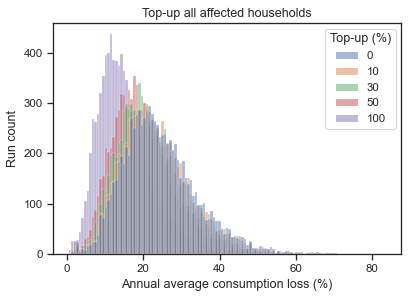

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

target_group = 'all'
top_ups = ['0', '10', '30', '50', '100']
df = outcomes[outcomes['target_group'] == target_group].copy()
df = df[df['top_up'].isin(top_ups)]
df['top_up'] = df['top_up'].astype(str)
df['top_up'] = pd.Categorical(df['top_up'], categories=top_ups, ordered=True)
df.rename(columns={'top_up': 'Top-up (%)'}, inplace=True)
outcome_of_interest = 'annual_average_consumption_loss_pct'
sns.histplot(data=df, x=outcome_of_interest, hue='Top-up (%)', ax=ax)
plt.xlabel('Annual average consumption loss (%)')
plt.ylabel('Run count')
plt.title('Top-up all affected households');

In [11]:
df.groupby('Top-up (%)').describe()[[outcome_of_interest]]

annual_average_consumption_loss_pct                                 \
                                         count       mean       std       min   
Top-up (%)                                                                      
0                                       9000.0  24.364035  9.855400  0.958236   
10                                      9000.0  23.566182  9.635883  0.901858   
30                                      9000.0  21.887582  9.167804  0.788630   
50                                      9000.0  20.094730  8.661158  0.675403   
100                                     9000.0  15.104425  7.247176  0.392334   

                                                        
                  25%        50%        75%        max  
Top-up (%)                                              
0           17.504726  23.011437  29.841804  83.561771  
10          16.843837  22.255881  28.899948  82.881352  
30          15.514117  20.618720  26.865713  81.190933  
50          14.083229  18.866170  24.715394  78.977269  
100         10.120934  13.942767  18.724905  70.092101

## How the top-up to `all` mitigates the impact of a flood?

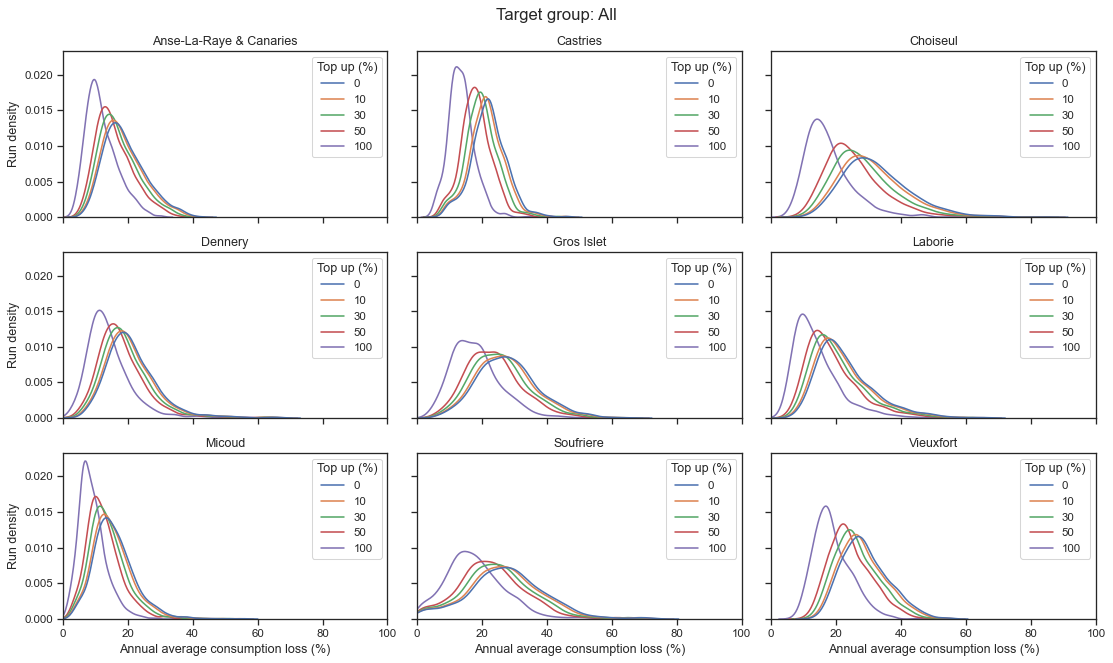

In [12]:
target_group = 'all'
top_ups = ['0', '10', '30', '50', '100']
df = outcomes[outcomes['target_group'] == target_group]
df = df[df['top_up'].isin(top_ups)]
df['top_up'] = pd.Categorical(df['top_up'], categories=top_ups, ordered=True)

districts = df['district'].unique().tolist()
n_districts = len(districts)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'

outcome_name_mapper = {'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)',
                       'n_new_poor': 'Number of new poor',
                       'n_new_poor_increase_pct' : 'Increase in number of new poor (%)'}


for district in districts:
    data = df[df['district'] == district][['top_up', outcome_of_interest]]
    data.sort_values('top_up', inplace=True)
    data.rename(columns={'top_up': 'Top up (%)'}, inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    # sns.histplot(data=data, 
    #              x=outcome_of_interest, 
    #              hue='Top up', 
    #              ax=ax[i, j], 
    #              # multiple='stack', 
    #              # shrink=.8,
    #              # palette="ch:rot=-.25,hue=1,light=.75"
    #              )
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up (%)', 
                 ax=ax[i, j], 
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_ylabel('Run density')
    ax[i, j].set_xlabel(outcome_name_mapper[outcome_of_interest])
    ax[i, j].set_xlim(0, 100)
fig.suptitle('Target group: ' + target_group_mapper[target_group], fontsize=16)
fig.tight_layout()

In [13]:
# Select target group
df = outcomes[outcomes['target_group'] == 'all']

# Select districts with low, mid and high consumption annual_average_consumption_loss_pct
districts_of_interest = ['Micoud', 'Laborie', 'Choiseul']
df = df[df['district'].isin(districts_of_interest)]

# Select top-ups of 0, 50 and 100
df = df[df['top_up'].isin(['0', '10', '30', '50', '100'])]
df['top_up'] = df['top_up'].astype('str')
df['top_up'] = pd.Categorical(df['top_up'], ['0', '10', '30', '50', '100'])
df.rename(columns={'top_up': 'Top-up (%)', 'district' : 'District', 'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)'}, inplace=True)
df.sort_values(by='District', inplace=True)

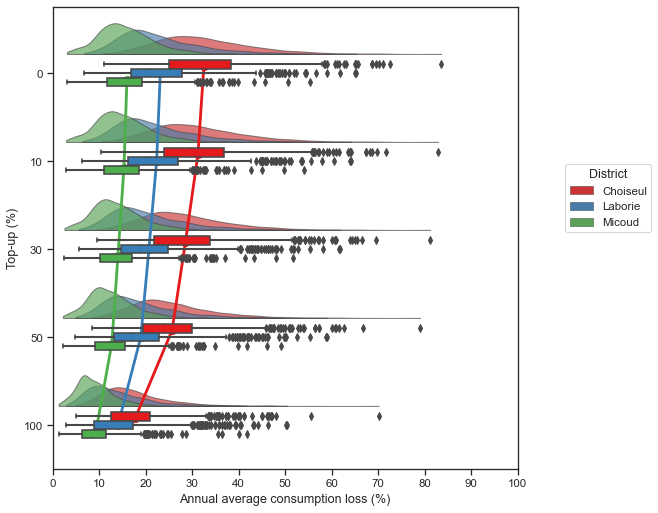

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = pt.RainCloud(x='Top-up (%)',
                  y='Annual average consumption loss (%)',
                  hue='District',
                  orient='h',
                  data=df,
                  palette='Set1',
                  bw=0.2,
                  width_viol=0.7,
                  width_box=0.3,
                  ax=ax,
                  cut=0,
                  alpha=0.65,
                  dodge=True,
                  pointplot=True,
                  stripplot=False,
                  move=0.2)
ax.set_xlim(0, 100)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(districts_of_interest)], labels[:len(
    districts_of_interest)], title='District', loc='lower right', bbox_to_anchor=(1.3, 0.5));
ax.xaxis.set_major_locator(MultipleLocator(10))

## Which policies are the most effective?

### Consumption loss

In [4]:
df = get_policy_effectiveness_tab(outcomes)

In [5]:
# How effective is the policy in reducing income loss?
df.groupby(['Policy']).mean(numeric_only=True)['Annual average consumption loss (%)'].sort_values(ascending=True).round(2)

Policy
100% to all                          15.10
50% to all                           20.09
100% to poor and near poor (2.0)     20.91
30% to all                           21.89
50% to poor and near poor (2.0)      22.77
100% to poor and near poor (1.25)    22.93
30% to poor and near poor (2.0)      23.44
10% to all                           23.57
100% to poor                         23.61
50% to poor and near poor (1.25)     23.70
30% to poor and near poor (1.25)     23.98
50% to poor                          24.01
10% to poor and near poor (2.0)      24.07
30% to poor                          24.16
10% to poor and near poor (1.25)     24.24
10% to poor                          24.30
None                                 24.36
Name: Annual average consumption loss (%), dtype: float64

In [6]:
# What about the effectiveness by district?
df = df.groupby(['District', 'Policy']).mean(numeric_only=True)[['Annual average consumption loss (%)']] 
df = df.sort_values(by=['District', 'Annual average consumption loss (%)'])

In [10]:
top_3_policies = {}
for district in outcomes['district'].unique():
    top_3_policies[district] = df.loc[district, :].iloc[:3].index.tolist()
top_3_policies = pd.DataFrame(top_3_policies).T
top_3_policies.columns = [1, 2, 3]

bottom_3_policies = {}
for district in outcomes['district'].unique():
    bottom_3_policies[district] = df.loc[district, :].iloc[-4:-1].index.tolist()
bottom_3_policies = pd.DataFrame(bottom_3_policies).T
bottom_3_policies.columns = [1, 2, 3]

In [12]:
top_3_policies

,1,2,3
Anse-La-Raye & Canaries,100% to all,50% to all,100% to poor and near poor (2.0)
Castries,100% to all,50% to all,100% to poor and near poor (2.0)
Choiseul,100% to all,50% to all,100% to poor and near poor (2.0)
Dennery,100% to all,100% to poor and near poor (2.0),50% to all
Gros Islet,100% to all,50% to all,30% to all
Laborie,100% to all,50% to all,100% to poor and near poor (2.0)
Micoud,100% to all,50% to all,100% to poor and near poor (2.0)
Soufriere,100% to all,50% to all,100% to poor and near poor (2.0)
Vieuxfort,100% to all,100% to poor and near poor (2.0),50% to all


In [11]:
bottom_3_policies

,1,2,3
Anse-La-Raye & Canaries,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Castries,30% to poor,10% to poor and near poor (1.25),10% to poor
Choiseul,30% to poor,10% to poor and near poor (1.25),10% to poor
Dennery,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Gros Islet,30% to poor,10% to poor and near poor (1.25),10% to poor
Laborie,30% to poor,10% to poor and near poor (1.25),10% to poor
Micoud,30% to poor,10% to poor and near poor (1.25),10% to poor
Soufriere,10% to poor and near poor (1.25),30% to poor,10% to poor
Vieuxfort,30% to poor,10% to poor and near poor (1.25),10% to poor


### Number of poor

In [17]:
df = get_policy_effectiveness_tab(outcomes)

In [19]:
# How effective is the policy in reducing income loss?
df.groupby(['Policy']).mean(numeric_only=True)['Number of new poor'].sort_values(ascending=True).round(2)

Policy
100% to all                           86.92
100% to poor and near poor (2.0)      97.19
50% to all                           118.39
50% to poor and near poor (2.0)      124.61
30% to all                           129.99
100% to poor and near poor (1.25)    130.81
30% to poor and near poor (2.0)      133.93
10% to all                           141.54
50% to poor and near poor (1.25)     141.57
10% to poor and near poor (2.0)      142.76
30% to poor and near poor (1.25)     144.12
10% to poor and near poor (1.25)     145.89
None                                 146.49
30% to poor                          146.49
10% to poor                          146.49
50% to poor                          146.49
100% to poor                         146.49
Name: Number of new poor, dtype: float64

In [20]:
# How effective is the policy in reducing number of new poor
df = df.groupby(['District', 'Policy']).mean(numeric_only=True)[['Number of new poor']] 
df = df.sort_values(by=['District', 'Number of new poor'])

In [22]:
df

Number of new poor
District                Policy                                               
Anse-La-Raye & Canaries 100% to all                                    44.212
                        100% to poor and near poor (2.0)               45.057
                        50% to all                                     59.612
                        50% to poor and near poor (2.0)                59.938
                        100% to poor and near poor (1.25)              60.024
...                                                                       ...
Vieuxfort               None                                          243.458
                        10% to poor                                   243.458
                        30% to poor                                   243.458
                        50% to poor                                   243.458
                        100% to poor                                  243.458

[153 rows x 1 columns]

In [23]:
top_3_policies = {}
for district in outcomes['district'].unique():
    top_3_policies[district] = df.loc[district, :].iloc[:3].index.tolist()
top_3_policies = pd.DataFrame(top_3_policies).T
top_3_policies.columns = [1, 2, 3]

bottom_3_policies = {}
for district in outcomes['district'].unique():
    bottom_3_policies[district] = df.loc[district, :].iloc[-4:-1].index.tolist()
bottom_3_policies = pd.DataFrame(bottom_3_policies).T
bottom_3_policies.columns = [1, 2, 3]

In [24]:
top_3_policies

,1,2,3
Anse-La-Raye & Canaries,100% to all,100% to poor and near poor (2.0),50% to all
Castries,100% to all,100% to poor and near poor (2.0),50% to all
Choiseul,100% to all,100% to poor and near poor (2.0),50% to all
Dennery,100% to all,100% to poor and near poor (2.0),50% to all
Gros Islet,100% to all,100% to poor and near poor (2.0),50% to all
Laborie,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Micoud,100% to all,100% to poor and near poor (2.0),50% to all
Soufriere,100% to all,100% to poor and near poor (2.0),50% to all
Vieuxfort,100% to all,100% to poor and near poor (2.0),50% to all


In [25]:
bottom_3_policies

,1,2,3
Anse-La-Raye & Canaries,10% to poor,30% to poor,50% to poor
Castries,10% to poor,30% to poor,50% to poor
Choiseul,30% to poor,50% to poor,100% to poor
Dennery,10% to poor,30% to poor,50% to poor
Gros Islet,10% to poor,30% to poor,50% to poor
Laborie,10% to poor,30% to poor,50% to poor
Micoud,10% to poor,30% to poor,50% to poor
Soufriere,10% to poor,30% to poor,50% to poor
Vieuxfort,10% to poor,30% to poor,50% to poor
